In [1]:
%pip install torch==2.0.0

In [2]:
# give colab permission to access drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Update these as required
repo_path = '/content/drive/MyDrive/github/subteams/LLMProbing'
odeformer_path = '/content/drive/MyDrive/aisc' # This is because I cloned the odeformer repo into my aisc folder
samples_path = '/content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/samples'
activations_path = '/content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/activations'
probes_path = '/content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes'

In [4]:
import sys
import importlib
sys.path.append(repo_path)
sys.path.append(odeformer_path)

In [5]:
import numpy as np
import os
import pickle

In [6]:
from odeformer.model import SymbolicTransformerRegressor
dstr = SymbolicTransformerRegressor(from_pretrained=True)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [7]:
model_args = {'beam_size': 10, 'beam_temperature': 0.1}
dstr.set_model_args(model_args)

In [8]:
%load_ext autoreload
%autoreload 2

## Random Sample Generation

In [9]:
from src.sample_generation import RandomSamplesGenerator

In [10]:
operators_to_use = "id:1,add:1,mul:1,sin:0.5"
min_dimension = 1
max_dimension = 1
num_samples = 10
seed = 42
sample_descriptor = 'demo'

random_samples_path = f'{samples_path}/demo_random'

In [11]:
rsg = RandomSamplesGenerator()

In [12]:
rsg.generate_random_samples(random_samples_path, seed=seed, num_samples=num_samples, \
                            operators_to_use=operators_to_use, min_dimension=min_dimension, \
                            max_dimension=max_dimension, sample_descriptor='demo')

Generating demo samples: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


[INFO] Data generation complete. Saved 10 demo samples to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/samples/demo_random


In [13]:
# Inspect a random sample to see its keys and some data
random_samples_dir = os.fsencode(random_samples_path)
for random_sample_file in os.listdir(random_samples_dir):
  random_sample_name = os.fsdecode(random_sample_file)
  random_sample_path = os.path.join(random_samples_path, random_sample_name)
  with open(random_sample_path, 'rb') as f:
      random_sample = pickle.load(f)
  print(random_sample.keys())
  print(f"Encoded equation: {random_sample['tree']}")
  print(f"Feature dictionary: {random_sample['feature_dict']}")
  break

dict_keys(['times', 'trajectory', 'tree_encoded', 'skeleton_tree_encoded', 'tree', 'skeleton_tree', 'infos', 'operator_dict', 'feature_dict'])
Encoded equation: -0.9998 * x_0
Feature dictionary: {'log': 0, 'exp': 0, 'tan': 0, 'arctan': 0, 'sin_cos': 0, 'arc_sin_cos': 0, 'pow2': 0, 'pow3': 0, 'inv': 0, 'sqrt': 0}


## Manual Sample Generation

In [14]:
from src.sample_generation import ManualSamplesGenerator

In [15]:
manual_samples_path = f'{samples_path}/demo_manual'
msg = ManualSamplesGenerator(samples_path=manual_samples_path)

In [16]:
# Times array
t_values = np.linspace(1, 10, 50)

# Exponential parameters
c_values = np.linspace(-10,10, 2)
a_values = np.linspace(-10,10, 5)

# Hyperbolic parameters
t0_values = np.linspace(10.1, 100, 5)

In [17]:
# Generate exponential samples
msg.generate_exponential_samples(t_values, c_values, a_values)

Generating exponential samples:   0%|          | 0/10 [00:00<?, ?it/s]

Saving generated samples: 10it [00:00, 81.45it/s]


[INFO] Data generation complete. Saved 10 exponential samples to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/samples/demo_manual


In [18]:
# Inspect an exponential sample to see its keys and some data
manual_samples_dir = os.fsencode(manual_samples_path)
for sample_file in os.listdir(manual_samples_dir):
  sample_name = os.fsdecode(sample_file)
  if "exp" in sample_name:
    exp_sample_path = os.path.join(manual_samples_path, sample_name)
    with open(exp_sample_path, 'rb') as f:
        exp_sample = pickle.load(f)
    print(exp_sample.keys())
    print(exp_sample['expression'])
    print(exp_sample['feature_dict'])
    break

dict_keys(['times', 'trajectory', 'parameters', 'feature_dict', 'expression'])
-10.0 * np.exp(10.0 * t)
{'exponential': 1, 'hyperbolic': 0}


In [19]:
# Generate hyperbolic samples
msg.generate_hyperbolic_samples(t_values, c_values, t0_values)

Generating hyperbolic samples:   0%|          | 0/10 [00:00<?, ?it/s]

Saving generated samples: 10it [00:00, 86.45it/s]


[INFO] Data generation complete. Saved 10 hyperbolic samples to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/samples/demo_manual


In [20]:
# Inspect a hyperbolic sample to see its keys and some data
manual_samples_dir = os.fsencode(manual_samples_path)
for sample_file in os.listdir(manual_samples_dir):
  sample_name = os.fsdecode(sample_file)
  if "hyp" in sample_name:
    hyp_sample_path = os.path.join(manual_samples_path, sample_name)
    with open(hyp_sample_path, 'rb') as f:
        hyp_sample = pickle.load(f)
    print(hyp_sample.keys())
    print(hyp_sample['expression'])
    print(hyp_sample['parameters'])
    print(hyp_sample['feature_dict'])
    break

dict_keys(['times', 'trajectory', 'parameters', 'feature_dict', 'expression'])
-10.0 / (10.1-t)
{'t0': 10.1, 'c': -10.0}
{'exponential': 0, 'hyperbolic': 1}


## Corresponding Activations Extraction

In [21]:
from src.activation_extraction import ActivationsExtractor

In [22]:
random_activations_path = f'{activations_path}/demo_random'
manual_activations_path = f'{activations_path}/demo_manual'

In [23]:
act_extractor = ActivationsExtractor()

In [24]:
act_extractor.extract_activations(dstr, random_samples_path, random_activations_path, layers_to_extract=['ffn'])

Extracting Activations: 100%|██████████| 10/10 [00:00<00:00, 180.12it/s]


Skipping sample: demo_534895718 (activation file already exists)

Skipping sample: demo_862061404 (activation file already exists)

Skipping sample: demo_199900595 (activation file already exists)

Skipping sample: demo_787846414 (activation file already exists)

Skipping sample: demo_996406378 (activation file already exists)

Skipping sample: demo_423734972 (activation file already exists)

Skipping sample: demo_127521863 (activation file already exists)

Skipping sample: demo_670094950 (activation file already exists)

Skipping sample: demo_841095289 (activation file already exists)

Skipping sample: demo_415968276 (activation file already exists)

[INFO] Activation extraction complete. Activations saved to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/activations/demo_random


In [25]:
act_extractor.extract_activations(dstr, manual_samples_path, manual_activations_path, layers_to_extract=['ffn'])

Extracting Activations:   0%|          | 0/20 [00:00<?, ?it/s]


Skipping sample: exp_0 (activation file already exists)

Skipping sample: exp_1 (activation file already exists)

Skipping sample: exp_3 (activation file already exists)

Skipping sample: exp_2 (activation file already exists)

Skipping sample: exp_6 (activation file already exists)

Skipping sample: exp_5 (activation file already exists)

Skipping sample: exp_4 (activation file already exists)

Skipping sample: exp_7 (activation file already exists)

Skipping sample: exp_8 (activation file already exists)

Skipping sample: exp_9 (activation file already exists)

Skipping sample: hyp_0 (activation file already exists)

Skipping sample: hyp_1 (activation file already exists)

Skipping sample: hyp_2 (activation file already exists)

Skipping sample: hyp_3 (activation file already exists)

Skipping sample: hyp_5 (activation file already exists)

Skipping sample: hyp_4 (activation file already exists)

Skipping sample: hyp_6 (activation file already exists)


Extracting Activations: 100%|██████████| 20/20 [00:00<00:00, 185.00it/s]


Skipping sample: hyp_7 (activation file already exists)

Skipping sample: hyp_8 (activation file already exists)

Skipping sample: hyp_9 (activation file already exists)

[INFO] Activation extraction complete. Activations saved to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/activations/demo_manual


In [26]:
# Inspect a random activation and display its keys and some values
random_acts_dir = os.fsencode(random_activations_path)
for acts_file in os.listdir(random_acts_dir):
  acts_name = os.fsdecode(acts_file)
  random_acts_path = os.path.join(random_activations_path, acts_name)
  with open(random_acts_path, 'rb') as f:
      random_acts = pickle.load(f)
  print(random_acts.keys())
  print(random_acts['feature_dict'])
  print(random_acts['r2_score'])
  print(random_acts['expression'])
  print(random_acts['pred_expression'])
  break

dict_keys(['encoder', 'decoder', 'operator_dict', 'feature_dict', 'r2_score', 'pred_expression', 'expression'])
{'log': 0, 'exp': 0, 'tan': 0, 'arctan': 0, 'sin_cos': 0, 'arc_sin_cos': 0, 'pow2': 0, 'pow3': 0, 'inv': 0, 'sqrt': 0}
0.9999999755587363
-0.9998 * x_0
x_0' = -1.0000000000000000 * x_0



In [27]:
# Inspect a manual activation and display its keys and some values
manual_acts_dir = os.fsencode(manual_activations_path)
for acts_file in os.listdir(manual_acts_dir):
  acts_name = os.fsdecode(acts_file)
  manual_acts_path = os.path.join(manual_activations_path, acts_name)
  with open(manual_acts_path, 'rb') as f:
      manual_acts = pickle.load(f)
  print(manual_acts.keys())
  print(manual_acts['feature_dict'])
  print(manual_acts['r2_score'])
  print(manual_acts['expression'])
  print(manual_acts['pred_expression'])
  break

dict_keys(['encoder', 'decoder', 'feature_dict', 'r2_score', 'pred_expression', 'expression'])
{'exponential': 1, 'hyperbolic': 0}
-0.028362499160339283
-10.0 * np.exp(10.0 * t)
x_0' = 8.41372 * x_0



## Probe Training

In [28]:
import experiments

In [29]:
dir(experiments)
# Current experiment functions supported:
#   - separability_testing

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'run_experiment',
 'separability_testing']

In [30]:
target_feature = 'exponential'
activations_path = manual_activations_path
demo_probes_path = f'{probes_path}/demo_exp'
lr = 0.01
num_epochs = 1
num_repeats = 2
layers = [idx for idx in range(16)]

In [31]:
demo_expt_results = experiments.separability_testing(target_feature=target_feature, activations_path=manual_activations_path, \
                     probes_path=demo_probes_path, \
                     lr=lr, num_epochs=num_epochs, \
                     layers=layers, num_repeats=num_repeats)

Repeat 0 of layer 0



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]



Training Set (Epoch 1 - Final): Loss 0.05465790629386902, Accuracy 0.125
Probe trained on layer 0: Test Set Loss 0.00035452190786600113, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_0_0.pt
Repeat 1 of layer 0



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]



Training Set (Epoch 1 - Final): Loss 0.04426798224449158, Accuracy 0.375
Probe trained on layer 0: Test Set Loss 2.1457626644405536e-06, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_0_1.pt
Repeat 0 of layer 1



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]



Training Set (Epoch 1 - Final): Loss 0.04264803230762482, Accuracy 0.625
Probe trained on layer 1: Test Set Loss 0.00026117896777222427, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_1_0.pt
Repeat 1 of layer 1



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]



Training Set (Epoch 1 - Final): Loss 0.04248829558491707, Accuracy 0.5625
Probe trained on layer 1: Test Set Loss 3.337850074558446e-06, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_1_1.pt
Repeat 0 of layer 2



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]



Training Set (Epoch 1 - Final): Loss 0.07006152719259262, Accuracy 0.375
Probe trained on layer 2: Test Set Loss 0.411988765001297, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_2_0.pt
Repeat 1 of layer 2



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]



Training Set (Epoch 1 - Final): Loss 0.07098400592803955, Accuracy 0.375
Probe trained on layer 2: Test Set Loss 0.08671104162931442, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_2_1.pt
Repeat 0 of layer 3



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]



Training Set (Epoch 1 - Final): Loss 0.048227421939373016, Accuracy 0.5
Probe trained on layer 3: Test Set Loss 35.506629943847656, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_3_0.pt
Repeat 1 of layer 3



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]



Training Set (Epoch 1 - Final): Loss 0.05396951362490654, Accuracy 0.5
Probe trained on layer 3: Test Set Loss 41.74501037597656, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_3_1.pt
Repeat 0 of layer 4



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]



Training Set (Epoch 1 - Final): Loss 0.2241860181093216, Accuracy 0.5
Probe trained on layer 4: Test Set Loss 6.360774219036074, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_4_0.pt
Repeat 1 of layer 4



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]



Training Set (Epoch 1 - Final): Loss 0.03939239680767059, Accuracy 0.75
Probe trained on layer 4: Test Set Loss 3.0998341441152775, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_4_1.pt
Repeat 0 of layer 5



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]



Training Set (Epoch 1 - Final): Loss 0.12564723193645477, Accuracy 0.5
Probe trained on layer 5: Test Set Loss 1.1190574144820857, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_5_0.pt
Repeat 1 of layer 5



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



Training Set (Epoch 1 - Final): Loss 0.03501882404088974, Accuracy 0.8125
Probe trained on layer 5: Test Set Loss 0.7145131826400615, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_5_1.pt
Repeat 0 of layer 6



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]



Training Set (Epoch 1 - Final): Loss 0.047501854598522186, Accuracy 0.5
Probe trained on layer 6: Test Set Loss 0.4648214131593704, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_6_0.pt
Repeat 1 of layer 6



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]



Training Set (Epoch 1 - Final): Loss 0.049973051995038986, Accuracy 0.5
Probe trained on layer 6: Test Set Loss 0.5674329549074173, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_6_1.pt
Repeat 0 of layer 7



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



Training Set (Epoch 1 - Final): Loss 0.043049924075603485, Accuracy 0.5
Probe trained on layer 7: Test Set Loss 0.6551757752895355, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_7_0.pt
Repeat 1 of layer 7



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



Training Set (Epoch 1 - Final): Loss 0.05023470148444176, Accuracy 0.5
Probe trained on layer 7: Test Set Loss 0.6631457805633545, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_7_1.pt
Repeat 0 of layer 8



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]



Training Set (Epoch 1 - Final): Loss 0.05419036000967026, Accuracy 0.5
Probe trained on layer 8: Test Set Loss 0.48717455565929413, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_8_0.pt
Repeat 1 of layer 8



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]



Training Set (Epoch 1 - Final): Loss 0.058689575642347336, Accuracy 0.25
Probe trained on layer 8: Test Set Loss 0.4626878350973129, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_8_1.pt
Repeat 0 of layer 9



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



Training Set (Epoch 1 - Final): Loss 0.04700568690896034, Accuracy 0.5
Probe trained on layer 9: Test Set Loss 0.21440967172384262, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_9_0.pt
Repeat 1 of layer 9



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]



Training Set (Epoch 1 - Final): Loss 0.04536478593945503, Accuracy 0.75
Probe trained on layer 9: Test Set Loss 0.32327553257346153, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_9_1.pt
Repeat 0 of layer 10



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]



Training Set (Epoch 1 - Final): Loss 0.04684990644454956, Accuracy 0.5
Probe trained on layer 10: Test Set Loss 0.1907372623682022, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_10_0.pt
Repeat 1 of layer 10



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]



Training Set (Epoch 1 - Final): Loss 0.05817430093884468, Accuracy 0.5
Probe trained on layer 10: Test Set Loss 0.1375561784952879, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_10_1.pt
Repeat 0 of layer 11



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]



Training Set (Epoch 1 - Final): Loss 0.05138526111841202, Accuracy 0.5
Probe trained on layer 11: Test Set Loss 0.45694027841091156, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_11_0.pt
Repeat 1 of layer 11



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]



Training Set (Epoch 1 - Final): Loss 0.05604877322912216, Accuracy 0.5
Probe trained on layer 11: Test Set Loss 0.5188421159982681, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_11_1.pt
Repeat 0 of layer 12



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]



Training Set (Epoch 1 - Final): Loss 0.039762359112501144, Accuracy 0.5625
Probe trained on layer 12: Test Set Loss 0.25918419659137726, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_12_0.pt
Repeat 1 of layer 12



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]



Training Set (Epoch 1 - Final): Loss 0.043313197791576385, Accuracy 0.625
Probe trained on layer 12: Test Set Loss 0.36564332246780396, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_12_1.pt
Repeat 0 of layer 13



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]



Training Set (Epoch 1 - Final): Loss 0.04630352184176445, Accuracy 0.5
Probe trained on layer 13: Test Set Loss 0.6470373198390007, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_13_0.pt
Repeat 1 of layer 13



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]



Training Set (Epoch 1 - Final): Loss 0.04111747071146965, Accuracy 0.625
Probe trained on layer 13: Test Set Loss 0.3218267932534218, Test Set Accuracy 1.0
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_13_1.pt
Repeat 0 of layer 14



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]



Training Set (Epoch 1 - Final): Loss 0.07795225828886032, Accuracy 0.5
Probe trained on layer 14: Test Set Loss 0.5208145827054977, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_14_0.pt
Repeat 1 of layer 14



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



Training Set (Epoch 1 - Final): Loss 0.0384380966424942, Accuracy 0.625
Probe trained on layer 14: Test Set Loss 0.5793816552031785, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_14_1.pt
Repeat 0 of layer 15



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]



Training Set (Epoch 1 - Final): Loss 0.048755668103694916, Accuracy 0.5
Probe trained on layer 15: Test Set Loss 1.659764653770253, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_15_0.pt
Repeat 1 of layer 15



Training LR Probe: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



Training Set (Epoch 1 - Final): Loss 0.07181479036808014, Accuracy 0.5
Probe trained on layer 15: Test Set Loss 0.7109376717125997, Test Set Accuracy 0.5
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/local_experiment_data/probes/demo_exp/probe_exponential_15_1.pt


In [32]:
demo_expt_results

,layer,run,test_loss,test_accuracy,test_fail_ids,final_train_loss,final_train_accuracy,final_val_loss,final_val_accuracy
0,0,0,0.000355,1.0,[],0.054658,0.1250,20.041088,0.0
1,0,1,0.000002,1.0,[],0.044268,0.3750,19.451593,0.0
2,1,0,0.000261,1.0,[],0.042648,0.6250,6.479182,0.0
3,1,1,0.000003,1.0,[],0.042488,0.5625,7.729250,0.0
4,2,0,0.411989,0.5,[hyp_2],0.070062,0.3750,6.312723,0.0
5,2,1,0.086711,1.0,[],0.070984,0.3750,9.365321,0.5
6,3,0,35.506630,0.5,[exp_3],0.048227,0.5000,44.809975,0.5
7,3,1,41.745010,0.5,[hyp_2],0.053970,0.5000,41.514088,0.5
8,4,0,6.360774,0.5,[hyp_2],0.224186,0.5000,6.025636,0.5
9,4,1,3.099834,0.5,[exp_3],0.039392,0.7500,8.208691,0.5


In [33]:
import experiments.utils as expt_utils

demo_expt_summary = expt_utils.summarise_experiment(demo_expt_results)

In [34]:
demo_expt_summary

,layer,accuracy_mean,accuracy_std,loss_mean,loss_std
0,0,1.00,0.000000,0.000178,0.000249
1,1,1.00,0.000000,0.000132,0.000182
2,2,0.75,0.353553,0.249350,0.230006
3,3,0.50,0.000000,38.625820,4.411201
4,4,0.50,0.000000,4.730304,2.305833
5,5,0.50,0.000000,0.916785,0.286056
6,6,0.75,0.353553,0.516127,0.072557
7,7,0.50,0.000000,0.659161,0.005636
8,8,0.75,0.353553,0.474931,0.017315
9,9,1.00,0.000000,0.268843,0.076980


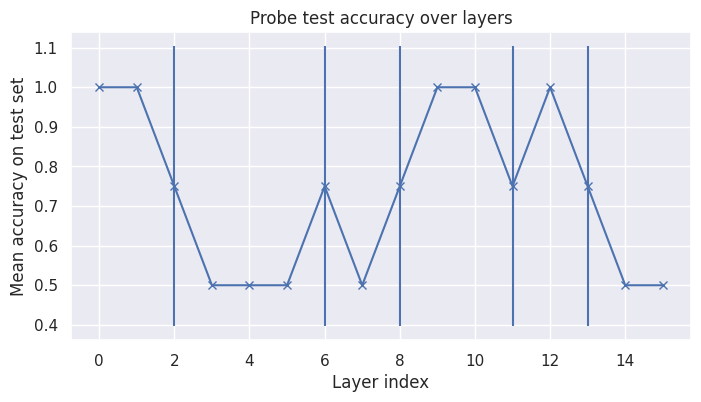

In [35]:
expt_utils.plot_from_summary(demo_expt_summary, descriptor='demo')

## Probe Loading and Evaluation

In [36]:
# TODO: write extra loading functionality for running an experiment using pretrained
# TODO: extend failure detection functionality